# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-25 21:17:52--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-25 21:17:52--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1a351e1e2f411b7339f7cd5a82.dl.dropboxusercontent.com/cd/0/inline/CN_e4za27PcdRXlmHLlKCW1ANGGNru7v84JPXiZYXMfJutLjgZqJB5-523pEpd5LWpwzOjO_4jV8d5LuPqtYUgFeynPs8K8OINZbDUVWP4zUgyLQL693IYGGoNmNtyrY4c0/file# [following]
--2024-02-25 21:17:52--  https://uc1a351e1e2f411b7339f7cd5a82.dl.dropboxusercontent.com/cd/0/inline/CN_e4za27PcdRXlmHLlKCW1ANGGNru7v84JPXiZYXMfJutLjgZqJB5-523pEpd5LWpwzOjO_4jV

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

Loading training images and labels
Training images and labels loaded
Plotting images and label maps


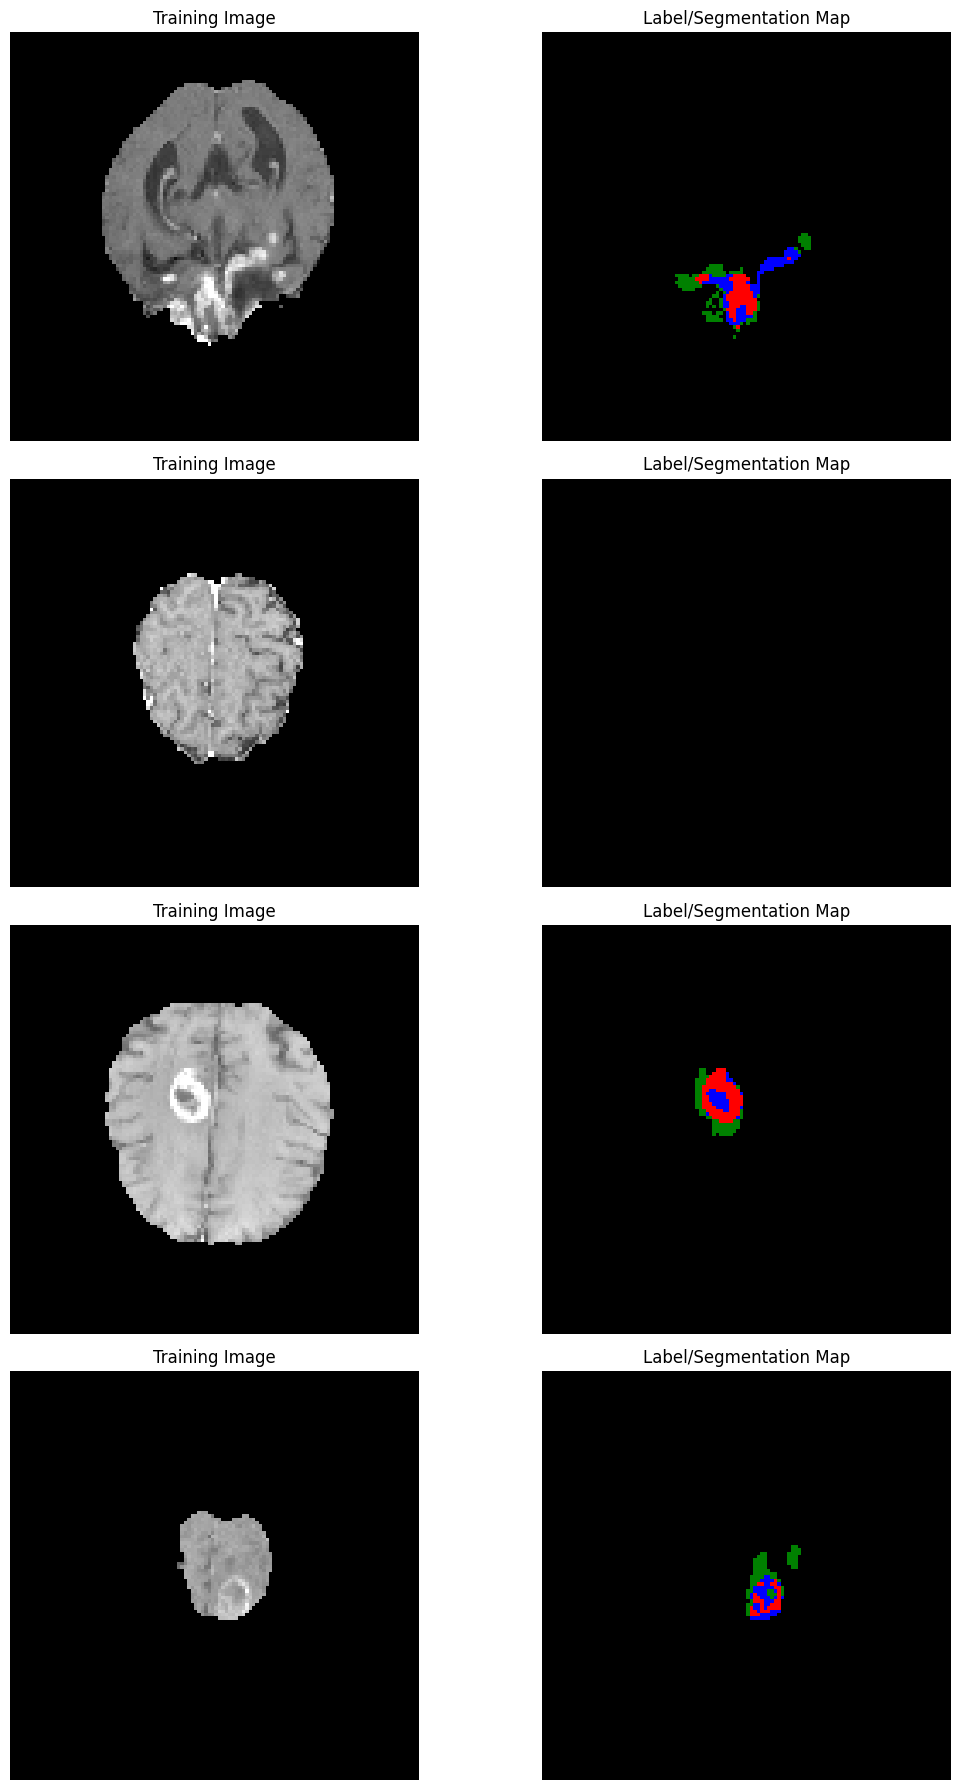

Visualization complete


In [4]:
### Insert your code ###
train_image_dir = './Task01_BrainTumour_2D/training_images/'
train_label_dir = './Task01_BrainTumour_2D/training_labels/'

print("Loading training images and labels")

# Load images and labels using list comprehension
train_images = [np.array(Image.open(os.path.join(train_image_dir, filename)))
                for filename in os.listdir(train_image_dir) if filename.endswith('.png')]
train_labels = [np.array(Image.open(os.path.join(train_label_dir, filename)))
                for filename in os.listdir(train_label_dir) if filename.endswith('.png')]

print("Training images and labels loaded")

# Defining color maps for visualization.
cmap_brain_mr = 'gray'
cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Plot the images and their label maps.
print("Plotting images and label maps")

fig, axes = plt.subplots(4, 2, figsize=(12, 18))

rand_image = np.random.choice(len(train_images), 4, replace=False)

for i, idx in enumerate(rand_image):
    image = train_images[idx]
    label_map = train_labels[idx]

    # Plotting the training image.
    axes[i, 0].imshow(image, cmap=cmap_brain_mr)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Training Image')

    # Plotting the label map.
    axes[i, 1].imshow(label_map, cmap=cmap_segmentation, vmin=0, vmax=3)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Label/Segmentation Map')

plt.tight_layout()
plt.show()

print("Visualization complete")
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [5]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # Ensure image is a numpy array
    image = np.array(image)
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        rand_batch = np.random.choice(len(self), batch_size, replace=False)

        for idx in rand_batch:
            image, label = self[idx]
            images.append(image)
            labels.append(label)
        ### End of your code ###
        #print(images.shape)
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [6]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        self.upconv3 = nn.ConvTranspose2d(n, n // 2, kernel_size=4, stride=2, padding=1)
        self.conv3d = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU()
        )

        n //= 2  # 64
        self.upconv2 = nn.ConvTranspose2d(n, n // 2, kernel_size=4, stride=2, padding=1)
        self.conv2d = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU()
        )

        n //= 2  # 32
        self.upconv1 = nn.ConvTranspose2d(n, n // 2, kernel_size=4, stride=2, padding=1)
        self.conv1d = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, output_channel, kernel_size=1)  # Output segmentation map
        )
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x1 = self.conv1(x)
        conv1_skip = x1
        #print(x1.size())

        x2 = self.conv2(x1)
        conv2_skip = x2
        #print(x2.size())

        x3 = self.conv3(x2)
        conv3_skip = x3
        #print(x3.size())

        x4 = self.conv4(x3)
        #print(x4.size())

        # Decoder
        ### Insert your code ###
        x = self.upconv3(x4)
        #print(x.size())
        #print(x3.size())
        x = torch.cat([x, x3], dim=1)
        #print(x.size())
        x = self.conv3d(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2d(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv1d(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [7]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = np.stack(images), np.stack(labels) # Convert list to numpy array
    #print(images.shape)  # Add this line to print the shape of images
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.unsqueeze(1), labels  # Add a batch dimension to images
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    print("Training [{}/{}]: Loss: {:.3f}".format(it, num_iter, loss.item()))
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_loss = 0
            num_batches = (len(test_set) // eval_batch_size)

            for i in range(num_batches):

                start_idx = (i * eval_batch_size)
                end_idx = (start_idx + eval_batch_size)

                images, labels = test_set[start_idx:end_idx]
                images, labels = np.stack(images), np.stack(labels)  # Convert list to numpy array
                images, labels = torch.from_numpy(images), torch.from_numpy(labels)
                images, labels = images.unsqueeze(1), labels  # Add a batch dimension to images
                images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

                logits = model(images)
                test_loss = (test_loss + criterion(logits, labels).item())

            test_loss = (test_loss / num_batches)
            print("Test Loss: {:.3f}".format(test_loss))
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-5-0055689bb296>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-5-0055689bb296>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Streaming output truncated to the last 5000 lines.
Training [5052/10000]: Loss: 0.018
Training [5053/10000]: Loss: 0.016
Training [5054/10000]: Loss: 0.017
Training [5055/10000]: Loss: 0.013
Training [5056/10000]: Loss: 0.023
Training [5057/10000]: Loss: 0.018
Training [5058/10000]: Loss: 0.015
Training [5059/10000]: Loss: 0.016
Training [5060/10000]: Loss: 0.016
Training [5061/10000]: Loss: 0.010
Training [5062/10000]: Loss: 0.011
Training [5063/10000]: Loss: 0.018
Training [5064/10000]: Loss: 0.013
Training [5065/10000]: Loss: 0.014
Training [5066/10000]: Loss: 0.012
Training [5067/10000]: Loss: 0.013
Training [5068/10000]: Loss: 0.021
Training [5069/10000]: Loss: 0.012
Training [5070/10000]: Loss: 0.012
Training [5071/10000]: Loss: 0.010
Training [5072/10000]: Loss: 0.018
Training [5073/10000]: Loss: 0.023
Training [5074/10000]: Loss: 0.017
Training [5075/10000]: Loss: 0.017
Training [5076/10000]: Loss: 0.016
Training [5077/10000]: Loss: 0.012
Training [5078/10000]: Loss: 0.016
Trai

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

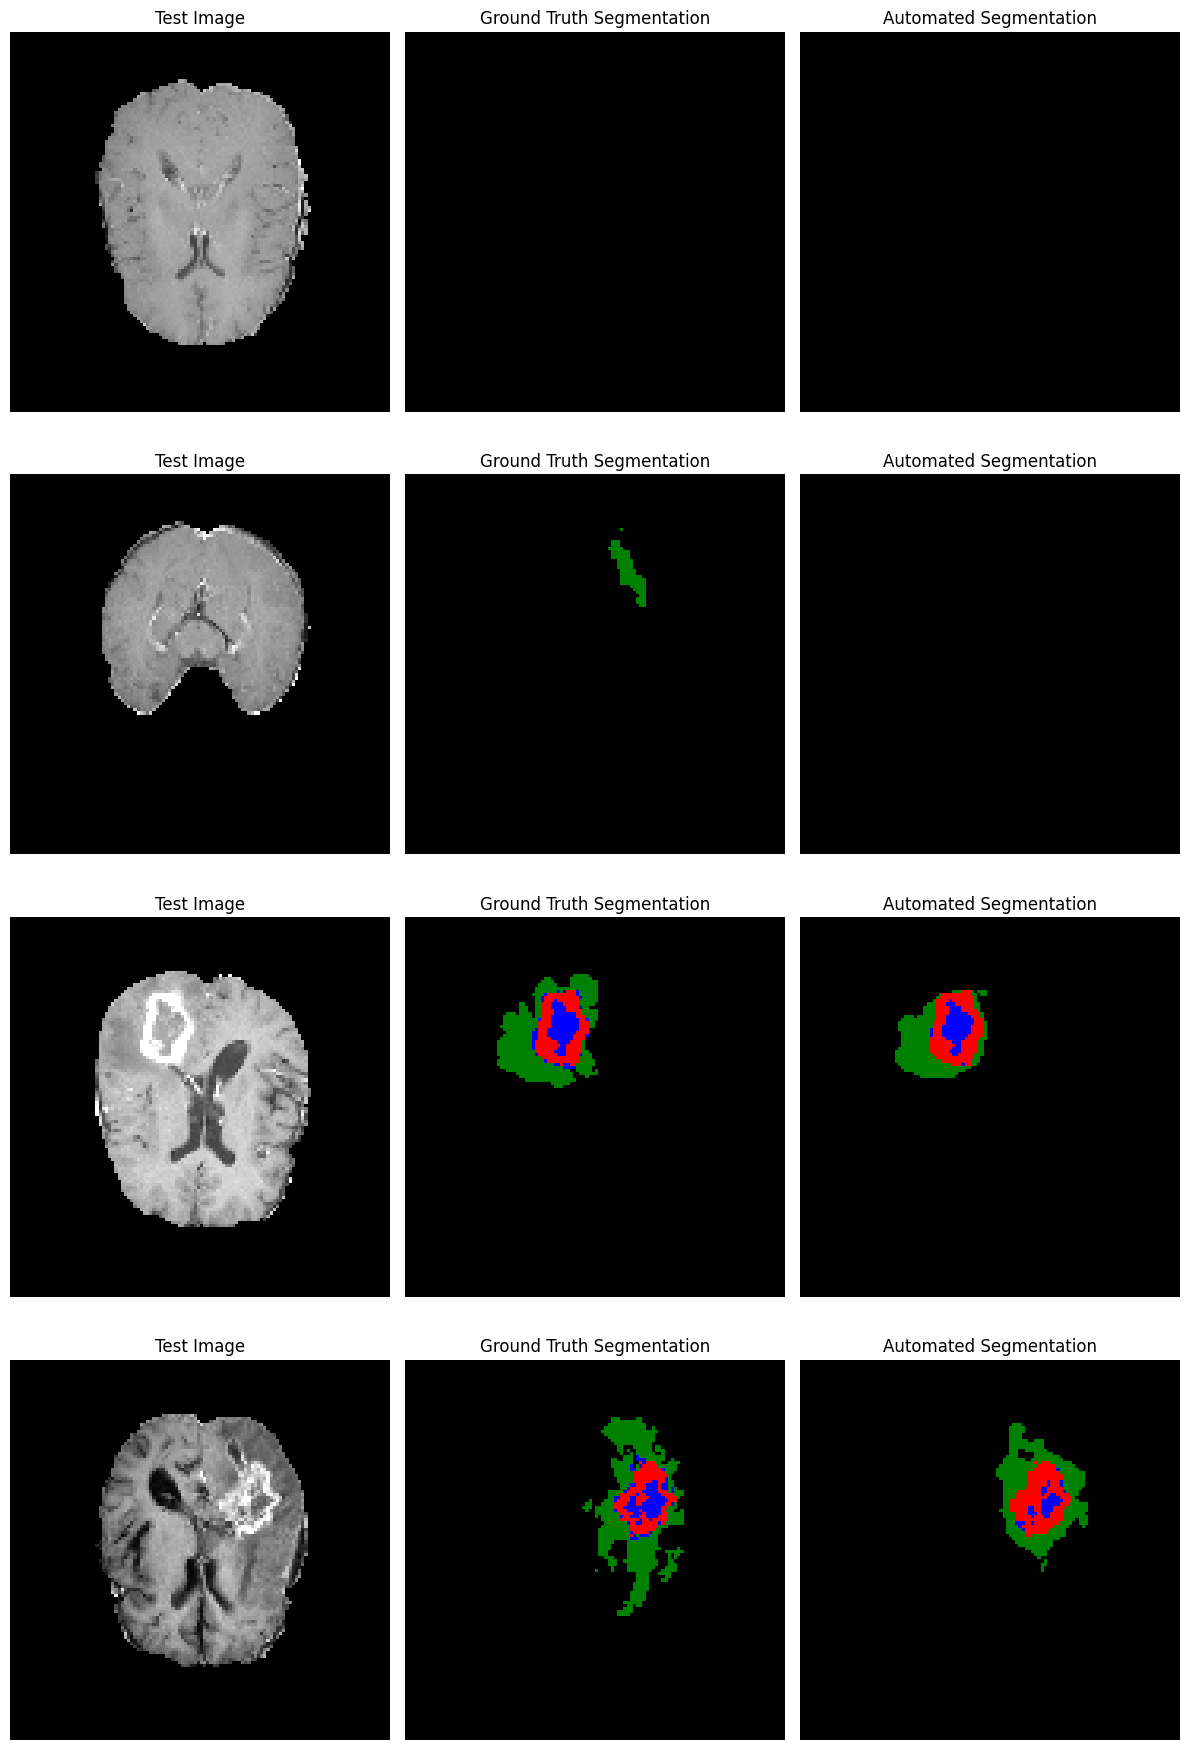

In [15]:
### Insert your code ###
def visualize_segmentation(images, labels, model):
    cmap_brain_mr = 'gray'
    cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])

    fig, axes = plt.subplots(4, 3, figsize=(12, 18))

    for ax_row, (image, label_map) in zip(axes, zip(images, labels)):
        # Plotting the test image.
        ax_row[0].imshow(image, cmap=cmap_brain_mr)
        ax_row[0].axis('off')
        ax_row[0].set_title('Test Image')

        # Plotting the ground truth segmentation.
        ax_row[1].imshow(label_map, cmap=cmap_segmentation, vmin=0, vmax=3)
        ax_row[1].axis('off')
        ax_row[1].set_title('Ground Truth Segmentation')

        # Perform automated segmentation
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
        logits = model(image_tensor)
        _, predicted_labels = torch.max(logits, dim=1)
        predicted_labels = predicted_labels.squeeze().cpu().numpy()

        # Plotting the automated segmentation.
        ax_row[2].imshow(predicted_labels, cmap=cmap_segmentation, vmin=0, vmax=3)
        ax_row[2].axis('off')
        ax_row[2].set_title('Automated Segmentation')

    plt.tight_layout()
    plt.show()


# Get a random set of 4 test images and labels
test_images, test_labels = test_set.get_random_batch(4)

# Visualize the automated segmentation
visualize_segmentation(test_images, test_labels, model)
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

In [ ]:
At first glance, it appears the trained model is able to differentiate the different parts of the brain MR with reasonable accuracy, labelling the background,
edema, non-enhancing and enhancing tumours similar to the ground truth segmentation. The model does not veer far from the ground truth, either over classifying
a class or under classifying slightly, as apparent in one of the test cases. It also appears that the average test loss equates to about 7%, which is a reasonable
error given the scope of this model. The loss values are relatively stable towards the end of training, suggesting that the model has converged to a stable solution.
The loss values during training appear to fluctuate around a relatively low value, with occasional spikes. This suggests that the model is learning effectively
overall, as the loss is decreasing over iterations.

However, a 7% average loss is not fit for a clinical environment as it may lead to misdiagnosis or confusion, where patients vary in the many 10s of thousands.
Some improvements that can be taken to reduce test loss, and also improve the output segmentation of the model include:
- Augmenting the training images with some image rotation, translation and scaling. This increases the diversity and difficulty of the training set, so that the
model may learn to better generalise an unknown test set, and increase in robustness.
- Try different variations of the UNet model, such as UNet+ to better capture the local and global features of the training and test images.
- Exploring alternative loss functions or custom loss functions tailored to the specific characteristics of the segmentation task can potentially lead to better
optimization and convergence of the model.